In [ ]:
!pip install -U typing_extensions openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.4 MB/s eta 0:00:00


In [ ]:
!pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 884.1 kB/s eta 0:00:00


# Create Pipeline

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoModelForSeq2SeqLM, AutoTokenizer, BitsAndBytesConfig
import transformers

from huggingface_hub import login

TOKEN = 'HUGGINGFACE_TOKEN'

CAUSALLM_MODELS = [
    "meta-llama/Llama-2-7b-hf",
    "decapoda-research/llama-7b-hf",
    "mistralai/Mistral-7B-v0.1",
    "ybelkada/falcon-7b-sharded-bf16",
    "facebook/galactica-1.3b",
    "microsoft/biogpt",
    "stanford-crfm/BioMedLM",
    "mistralai/Mistral-7B-Instruct-v0.1",
    "meta-llama/Llama-2-7b-chat-hf",
    "tiiuae/falcon-7b-instruct",
    "Jaykumaran17/mistral7b-finetuned-medical",
    "Laurent1/Mistral-7B-Instruct-v0.1-QLoRa-medical-QA",
    "TheBloke/Amethyst-13B-Mistral-GGUF",
    "meta-llama/Llama-2-13b-hf",
    "meta-llama/Llama-2-13b-chat-hf",
    "microsoft/Orca-2-13b",
    "microsoft/Orca-2-7b",
    "microsoft/phi-2",
    "mistralai/Mistral-7B-Instruct-v0.2",

]

SEQ2SEQ_MODELS = [
    "THUDM/glm-2b",
    "google/flan-t5-small",
    "razent/SciFive-base-Pubmed",
    "GanjinZero/biobart-v2-base",
]

def create_pipeline(model_name):

    device = "cuda:1" if torch.cuda.is_available() else "cpu"
    bnb_config = BitsAndBytesConfig(
        load_in_8bit=True,
        bnb_8bit_quant_type="nf8",
        bnb_8bit_compute_dtype=torch.float16,
    ) if device!='cpu' else None

    login(token=TOKEN)

    if model_name in CAUSALLM_MODELS:
        # Configure the pipeline for Causal Language Modeling

        model = AutoModelForCausalLM.from_pretrained(
            model_name,
            quantization_config=bnb_config,
            trust_remote_code=True
        )
        model.config.use_cache = False

        tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
        tokenizer.pad_token = tokenizer.eos_token

        pipeline = transformers.pipeline(
            "text-generation",
            model=model,
            tokenizer=tokenizer,
            torch_dtype=torch.float16,
            trust_remote_code=True,
            device_map=device,
        )
    elif model_name in SEQ2SEQ_MODELS:
        # Configure the pipeline for Sequence-to-Sequence Language Modeling
        model = AutoModelForSeq2SeqLM.from_pretrained(
            model_name,
            quantization_config=bnb_config,
            trust_remote_code=True
        )

        tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

        pipeline = transformers.pipeline(
            "text2text-generation",
            model=model,
            tokenizer=tokenizer,
            torch_dtype=torch.float16,
            trust_remote_code=True,
            device_map=device,
        )
    else:
        raise ValueError(f"Unsupported model_name: {model_name}")

    return pipeline

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoModelForSeq2SeqLM, AutoTokenizer, BitsAndBytesConfig
import transformers

from huggingface_hub import login

def create_zero_shot_pipeline(model_name):

    device = "cuda:1" if torch.cuda.is_available() else "cpu"

    bnb_config = BitsAndBytesConfig(
        load_in_8bit=True,
        bnb_8bit_quant_type="nf8",
        bnb_8bit_compute_dtype=torch.float16,
    ) if device!='cpu' else None

    login(token=TOKEN)

    if model_name in CAUSALLM_MODELS:
        # Configure the pipeline for Causal Language Modeling

        model = AutoModelForCausalLM.from_pretrained(
            model_name,
            quantization_config=bnb_config,
            trust_remote_code=True
        )
        model.config.use_cache = False

        tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
        tokenizer.pad_token = tokenizer.eos_token

        pipeline = transformers.pipeline(
            "zero-shot-classification",
            model=model,
            tokenizer=tokenizer,
            torch_dtype=torch.float16,
            trust_remote_code=True,
            device_map=device,
        )
    elif model_name in SEQ2SEQ_MODELS:
        # Configure the pipeline for Sequence-to-Sequence Language Modeling
        model = AutoModelForSeq2SeqLM.from_pretrained(
            model_name,
            quantization_config=bnb_config,
            trust_remote_code=True
        )

        tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

        pipeline = transformers.pipeline(
            "zero-shot-classification",
            model=model,
            tokenizer=tokenizer,
            torch_dtype=torch.float16,
            trust_remote_code=True,
            device_map=device,
        )
    else:
        raise ValueError(f"Unsupported model_name: {model_name}")

    return pipeline

In [ ]:
from openai import OpenAI
client = OpenAI(api_key = "")

response = client.completions.create(
  model="ft:gpt-4o-mini-2024-07-18:leaflab:s-analysis-tuned:9tSfa34T",
  prompt="Question: What mental health or wellness services and supports provided by your college are working well? What aspects of mental health and wellness need more attention? For the above question, a participant has given the following comment: i think getting more people to focus 'living on the now' would be very beneficial, a lot of my mental problems stem from either thinking too much of the past (friends i wished i stayed in touch with, social interaction i wished i acted differently in), or worrying too much about the future (what if i lose passion towards my major, what if some domino effect causes me to lose everything i ever cherished in my life) (notice these unhelpful what-ifs), so getting the idea of get out of your head, stop overthinking, and just do is something that has been helpful to me. Do you think the participant seems satisfied with the college services? Give your answer in one word: - if participant is satisfied or suggests nothing that needs attention, write SATISFIED - or if participant is not satisfied or writes about how the system can be improved, write NOT_SATISFIED - otherwise, write NEUTRAL Prediction: The participant seems",
  max_tokens=100,
)

print(response.choices[0].text)

In [ ]:
def pipeline_desc(msg, client, model="gpt-3.5-turbo", system_msg = None):

  if system_msg is None:
    system_msg = "You are a very experienced analyst, who is trying to analyze the answers to a question asked during a mental health survey. No answer will explicitly mention any of the categories. You have to analyse them based on the rules and answer one word, SATISFIED, DISSATISFIED, MIXED, or NEUTRAL.\n\nQuestion: Can you share your thoughts on the mental health or wellness services at your college? Identify aspects that are working well and areas that may need more attention.\n\nSince the question mentioned has two questions in itself. First, analyze which part of the answer corresponds to which part of the question. And then classify them based on the below rules:\n\n- SATISFIED (If at least 75% of the words are dedicated to expressing satisfaction and only a small portion of words are dedicated to suggestions for improvement.)\n- DISSATISFIED (If at least 75% of the words are dedicated to expressing dissatisfaction or suggestions for improvement, and there are little to no words that mention satisfaction.)\n- MIXED (If the words dedicated to expressing satisfaction and dissatisfaction/suggestions for improvement are almost equal (around 50% each).)\n- NEUTRAL (If there is no clear dedication of words towards satisfaction, dissatisfaction, or suggestions for improvement.)\n"

  response = client.chat.completions.create(
  model=model,
  messages=[
    {
      "role": "system",
      "content": system_msg
    },
    {
      "role": "user",
      "content": msg
    }
    ],
  temperature=.1,
  max_tokens=256,
  top_p=1,
  frequency_penalty=0,
  presence_penalty=0
  )
  return response.choices[0].message.content

# Prompts

In [ ]:
import re

#---------------------------------------------------------------------------------------------------------------
def strip_extra_spaces(text):
    # Remove leading and trailing whitespaces
    stripped_text = text.strip()

    # Remove extra spaces within the string using regular expression
    stripped_text = re.sub(' +', ' ', stripped_text)

    return stripped_text

#---------------------------------------------------------------------------------------------------------------
def prep_prompt_classification_summarization(row):

  comment = strip_extra_spaces(row['Comment'])

  prompt = f"""
Surveyor: What mental health or wellness services and supports provided by your college are working well? What aspects of mental health and wellness need more attention?
Respondent: {comment}

Summarize the sentiments of the respondent about the mental health services in one sentence.
Summary:
"""
  return prompt

#---------------------------------------------------------------------------------------------------------------
def prep_prompt_classification_with_direct_labels(row):

  comment = strip_extra_spaces(row['Comment'])

  prompt = f"""
Surveyor: What mental health or wellness services and supports provided by your college are working well? What aspects of mental health and wellness need more attention?
Respondent: {comment}

Question: What is the sentiment of the respondent about the mental health services?
Choices:
SATISFIED
DISSATISFIED
MIXED
NEUTRAL

Answer:
From the above choices, sentiment of the respondent about the mental health services is - Choice """

  return prompt

#---------------------------------------------------------------------------------------------------------------
def prep_prompt_classification_with_desc(row):

  comment = strip_extra_spaces(row['Comment'])

  prompt = f"""
Surveyor: Can you share your thoughts on the mental health or wellness services at your college? Identify aspects that are working well and areas that may need more attention.

Respondent: {comment}

Question: How would you describe your overall sentiment about the mental health services?

Choices:

SATISFIED (Select if the comment reflects a high level (atleast 75%) of satisfaction, with little or no suggestions for improvement.)
DISSATISFIED (Select if the comment expresses a high level (atleast 75%) of dissatisfaction or dedicates a significant portion (atleast 75%) to suggesting improvements.)
MIXED (Select if the comment shows a balanced mix (50% each) of satisfaction and dissatisfaction/(suggestions for improvement).)
NEUTRAL (Select if there is no direct/indirect satisfation/dissatisfaction/suggestions and the respondent has not personally used or experienced mental health services.)

Answer:

From the above choices, the sentiment of the respondent about the mental health services is - Choice """
  return prompt

#---------------------------------------------------------------------------------------------------------------
def prep_prompt_classification_few_short(row):

  comment = strip_extra_spaces(row['Comment'])

  prompt = f"""

Surveyor: What mental health or wellness services and supports provided by your college are working well? What aspects of mental health and wellness need more attention?

Question: What is the sentiment of the respondent about the mental health services?
Choices:
SATISFIED (Select if the respondent reflects a high level (atleast 75%) of satisfaction, with little or no suggestions for improvement.)
DISSATISFIED (Select if the respondent expresses a high level (atleast 75%) of dissatisfaction or dedicates a significant portion (atleast 75%) to suggesting improvements.)
MIXED (Select if the comment shows a balanced mix (50% each) of satisfaction and dissatisfaction/(suggestions for improvement).)
NEUTRAL (Select if there is no direct/indirect satisfation/dissatisfaction/suggestions and the respondent has not personally used or experienced mental health services.)

From the above choices, select the sentiment of the respondent about the mental health services in college-

Respondent: I am not happy with the mental health services at my college. They are too expensive and not covered by my insurance, they are too far away and not easily accessible by public transportation, and they are too inflexible and do not accommodate my schedule or preferences. The only redeeming quality they have is that they have some qualified and experienced counselors who are professional and courteous.
Answer: DISSATISFIED

Respondent: I am very pleased with the mental health services at my college. They have a comprehensive and integrated approach to wellness, offering not only counseling, but also physical, social, and spiritual support. The counselors are attentive, compassionate, and respectful of my identity and background. I feel like they really care about me and my well-being. The only thing I would suggest is to have more outreach and awareness campaigns to encourage more students to use their services.
Answer: SATISFIED

Respondent: I am somewhat satisfied with the mental health services at my college. They have some benefits, such as being confidential and respectful of my privacy, having some qualified and experienced counselors who are professional and courteous, and having a safe and comfortable space where I can relax and vent. They also have some drawbacks, such as being generic and not tailored to my needs and goals, being passive and not engaging or motivating me, and being isolated and not collaborating with other campus or community services.
Answer: MIXED

Respondent: I have not had any interaction or involvement with the mental health services at my college, so I do not have any impression or evaluation of them.
Answer: NEUTRAL

Respondent: {comment}
Answer:
 - Choice """

  return prompt

#---------------------------------------------------------------------------------------------------------------
def prep_prompt_classification_with_tuned_desc_codify(row):

  comment = strip_extra_spaces(row['Comment'])

  prompt = f"""
Surveyor: Can you share your thoughts on the mental health or wellness services at your college? Identify aspects that are working well and areas that may need more attention.

Respondent: {comment}

Question: How would you describe your overall sentiment about the mental health services?


def predict(comment):

  if (Select if the respondent reflects a high level (atleast 75%) of satisfaction, with little or no suggestions for improvement.):
    return 'SATISFIED'
  elif (Select if the respondent expresses a high level (atleast 75%) of dissatisfaction or dedicates a significant portion (atleast 75%) to suggesting improvements.):
    return 'DISSATISFIED'
  elif (Select if the comment shows a balanced mix (50% each) of satisfaction and dissatisfaction/(suggestions for improvement).):
    return 'MIXED'
  elif (Select if there is no direct/indirect satisfation/dissatisfaction/suggestions and the respondent has not personally used or experienced mental health services.):
    return 'NEUTRAL'

>>> predict(respondent's comment)
"""
  return prompt

#---------------------------------------------------------------------------------------------------------------

def prep_prompt_classification_with_role_prompting(row):

  comment = strip_extra_spaces(row['Comment'])

  prompt = f"""

Surveyor: Can you share your thoughts on the mental health or wellness services at your college? Identify aspects that are working well and areas that may need more attention.

Respondent: {comment}

Question: How would you describe your overall sentiment about the mental health services?

Choices:

SATISFIED (Select if the comment reflects a high level (atleast 75%) of satisfaction, with little or no suggestions for improvement.)
DISSATISFIED (Select if the comment expresses a high level (atleast 75%) of dissatisfaction or dedicates a significant portion (atleast 75%) to suggesting improvements.)
MIXED (Select if the comment shows a balanced mix (50% each) of satisfaction and dissatisfaction/(suggestions for improvement).)
NEUTRAL (Select if there is no direct/indirect satisfation/dissatisfaction/suggestions and the respondent has not personally used or experienced mental health services.)

Answer:

From the above choices, the sentiment of the respondent about the mental health services is - Choice
"""
  return prompt

#---------------------------------------------------------------------------------------------------------------

def prep_prompt_classification_with_zero_shot_COT(row):

  comment = strip_extra_spaces(row['Comment'])

  prompt = f"""

Surveyor: Can you share your thoughts on the mental health or wellness services at your college? Identify aspects that are working well and areas that may need more attention.

Respondent: {comment}

Question: How would you describe your overall sentiment about the mental health services?

Choices:

SATISFIED (Select if the comment reflects a high level (atleast 75%) of satisfaction, with little or no suggestions for improvement.)
DISSATISFIED (Select if the comment expresses a high level (atleast 75%) of dissatisfaction or dedicates a significant portion (atleast 75%) to suggesting improvements.)
MIXED (Select if the comment shows a balanced mix (50% each) of satisfaction and dissatisfaction/(suggestions for improvement).)
NEUTRAL (Select if there is no direct/indirect satisfation/dissatisfaction/suggestions and the respondent has not personally used or experienced mental health services.)

Answer:

Let’s think step by step, and give me an answer in one word.

From the above choices, the sentiment of the respondent about the mental health services is - Choice
"""
  return prompt

#---------------------------------------------------------------------------------------------------------------

def prep_prompt_classification_with_few_shot_COT(row):

  comment = strip_extra_spaces(row['Comment'])

  prompt = f"""

Surveyor: What mental health or wellness services and supports provided by your college are working well? What aspects of mental health and wellness need more attention?

Question: What is the sentiment of the respondent about the mental health services?

Choices:
SATISFIED (Select if the respondent reflects a high level (atleast 75%) of satisfaction, with little or no suggestions for improvement.)
DISSATISFIED (Select if the respondent expresses a high level (atleast 75%) of dissatisfaction or dedicates a significant portion (atleast 75%) to suggesting improvements.)
MIXED (Select if the comment shows a balanced mix (50% each) of satisfaction and dissatisfaction/(suggestions for improvement).)
NEUTRAL (Select if there is no direct/indirect satisfation/dissatisfaction/suggestions and the respondent has not personally used or experienced mental health services.)

From the above choices, select the sentiment of the respondent about the mental health services in college-

Respondent: I am not happy with the mental health services at my college. They are too expensive and not covered by my insurance, they are too far away and not easily accessible by public transportation, and they are too inflexible and do not accommodate my schedule or preferences. The only redeeming quality they have is that they have some qualified and experienced counselors who are professional and courteous.
Answer: The comment has only one line which shows satisfaction which is about qualified and experienced counselors. Rest all is dissatisfaction. Thus overall the comment is DISSATISFIED.

Respondent: I am very pleased with the mental health services at my college. They have a comprehensive and integrated approach to wellness, offering not only counseling, but also physical, social, and spiritual support. The counselors are attentive, compassionate, and respectful of my identity and background. I feel like they really care about me and my well-being. The only thing I would suggest is to have more outreach and awareness campaigns to encourage more students to use their services.
Answer: The comment mentions one suggestion and evrything else is satisfactory, thus overall the comment is SATISFIED.

Respondent: I am somewhat satisfied with the mental health services at my college. They have some benefits, such as being confidential and respectful of my privacy, having some qualified and experienced counselors who are professional and courteous, and having a safe and comfortable space where I can relax and vent. They also have some drawbacks, such as being generic and not tailored to my needs and goals, being passive and not engaging or motivating me, and being isolated and not collaborating with other campus or community services.
Answer: The comment is distributed into two categories. Based upon the length first half is satisfaction and second half is dissatisfaction. Thus overall the comment is MIXED.

Respondent: I have not had any interaction or involvement with the mental health services at my college, so I do not have any impression or evaluation of them.
Answer: The comment has no direct or indirect satisfaction or dissatisfaction. And in the comment mental health in college is dicussed, thus overall the comment is NEUTRAL.

Respondent: {comment}
Answer:
 - Choice """

  return prompt

#---------------------------------------------------------------------------------------------------------------

def prep_prompt_classification_with_tree_of_thoughts(row):

  comment = strip_extra_spaces(row['Comment'])

  prompt = f"""

Surveyor: What mental health or wellness services and supports provided by your college are working well? What aspects of mental health and wellness need more attention?

Respondent: {comment}

Simulate three brilliant, logical experts collaboratively answering a question. Each one verbosely explains their thought process in real-time, considering the prior explanations of others and openly acknowledging mistakes. At each step, whenever possible, each expert refines and builds upon the thoughts of others, acknowledging their contributions. They continue until there is a definitive answer to the question. For clarity, your entire response should be in a markdown table.
The question is ...
Question: What is the sentiment of the respondent about the mental health services?

Choices:
SATISFIED (Select if the respondent reflects a high level (atleast 75%) of satisfaction, with little or no suggestions for improvement.)
DISSATISFIED (Select if the respondent expresses a high level (atleast 75%) of dissatisfaction or dedicates a significant portion (atleast 75%) to suggesting improvements.)
MIXED (Select if the comment shows a balanced mix (50% each) of satisfaction and dissatisfaction/(suggestions for improvement).)
NEUTRAL (Select if there is no direct/indirect satisfation/dissatisfaction/suggestions and the respondent has not personally used or experienced mental health services.)

From the above choices, select the sentiment of the respondent about the mental health services in college and answer in one word-

Answer:
 - Choice """

  return prompt

#---------------------------------------------------------------------------------------------------------------

def prep_prompt_classification_with_steps_few_shot_COT(row):

  comment = strip_extra_spaces(row['Comment'])

  prompt = f"""

Surveyor: What mental health or wellness services and supports provided by your college are working well? What aspects of mental health and wellness need more attention?

Question: What is the sentiment of the respondent about the mental health services?

Follow these steps, to tell the sentiment of the comment:
1. Read the question once and now identify which part of the respondent's comment is talking about which part of the question. The respondent might not always straightforwardly mention things.
2. Identify which part of the comment talks about the services and support by the college that are working well (SATISFIED) and which part talks about the aspects that need more attention (DISSATISFIED).
3. Check the amount of words in each category and if one overpowers the other, then that is the sentiment of the comment.
4. If both categories contribute equally to the comment, then the sentiment is MIXED.
5. If the comment does not have any SATISFACTION or DISSATISFACTION, then the sentiment is NEUTRAL.
6. Finally output the sentiment of the comment in one word.

See the below examples to understand the above steps:

Respondent: caps /n more attention to make services more appealing for students to attend
1. caps is the answer to this part of the question (What mental health or wellness services and supports provided by your college are working well?)
 more attention to make services more appealing for students to attend is the answer to this part of the question (What aspects of mental health and wellness need more attention?)
2. caps is SATISFIED and more attention to make services more appealing for students to attend is DISSATISFIED.
3. DISSATISFIED overpowers SATISFIED, thus the sentiment of the comment is DISSATISFIED.
Answer: DISSATISFIED

Respondent: the counselors are great but there are not enough of them
1. the counselors are great is the answer to this part of the question (What mental health or wellness services and supports provided by your college are working well?)
 there are not enough of them is the answer to this part of the question (What aspects of mental health and wellness need more attention?)
2. the counselors are great and are SATISFIED and there are not enough of them are DISSATISFIED.
3. both categories contribute equally to the comment, thus the sentiment of the comment is MIXED.
Answer: MIXED

Respondent: {comment}
Answer:
 """

  return prompt

#---------------------------------------------------------------------------------------------------------------

def prep_prompt_classification_with_steps_few_shot_COT1(row):

  comment = strip_extra_spaces(row['Comment'])

  prompt = f"""

Surveyor: What mental health or wellness services and supports provided by your college are working well? What aspects of mental health and wellness need more attention?

Question: What is the sentiment of the respondent about the mental health services?

Follow these steps, to tell the sentiment of the comment:
1. Carefully read the question and analyze the respondent's comment, considering that respondents may not always express their thoughts explicitly.
2. Categorize the comment into two sections: one addressing the positive aspects of the college's mental health services (SATISFIED) and the other pointing out areas that need improvement (DISSATISFIED).
3. Evaluate the word count in each category, and if one category significantly outweighs the other, use that as the overall sentiment of the comment.
4. In cases where both categories contribute equally, categorize the sentiment as MIXED.
5. If the comment does not convey either satisfaction or dissatisfaction, label the sentiment as NEUTRAL.
6. Conclude by summarizing the sentiment of the comment in one word.

See the below examples to understand the above steps:

Example 1:
Respondent: "Caps /n more attention to make services more appealing for students to attend"
Identify the positive aspect of the college's mental health services: "Caps" answers the question, "What mental health or wellness services and supports provided by your college are working well?"
Identify the area that requires improvement: "More attention to make services more appealing for students to attend" addresses the question, "What aspects of mental health and wellness need more attention?"
Assess the sentiment:
"Caps" contributes to SATISFACTION.
"More attention to make services more appealing for students to attend" indicates DISSATISFACTION.
Determine the overall sentiment:
As DISSATISFACTION overpowers SATISFACTION, the sentiment of the comment is DISSATISFIED.
Answer: DISSATISFIED

Example 2:
Respondent: "The counselors are great, but there are not enough of them"
Identify the positive aspect of the college's mental health services: "The counselors are great" answers the question, "What mental health or wellness services and supports provided by your college are working well?"
Identify the area that requires improvement: "There are not enough of them" addresses the question, "What aspects of mental health and wellness need more attention?"
Assess the sentiment:
"The counselors are great" contributes to SATISFACTION.
"There are not enough of them" indicates DISSATISFACTION.
Determine the overall sentiment:
Both categories contribute equally to the comment, making the sentiment MIXED.
Answer: MIXED

Respondent: {comment}
Answer:
 """

  return prompt

# Fine-tuned GPT-3.5

In [ ]:
type(x_test)

list

In [ ]:
!pip install -U typing_extensions openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.7 MB/s eta 0:00:00


In [ ]:
import json
import os

# Function to load JSON from a file
def load_json(folder_path, file_name):
    file_path = os.path.join(folder_path, file_name)
    with open(file_path, "r") as f:
        data = json.load(f)
    return data

# Function to load all JSONs (train, val, test, mapping) into respective variables
def load_all_jsons(folder_path):
    train = load_json(folder_path, "train.json")
    val = load_json(folder_path, "val.json")
    test = load_json(folder_path, "test.json")
    mapping = load_json(folder_path, "mapping.json")

    return train, val, test, mapping

# Example usage:
output_folder = "../data/splits/"
train, val, test, mapping = load_all_jsons(output_folder)

In [ ]:
import numpy as np

x_train = [record['text'] for record in train]
y_train = np.asarray([record['label'] for record in train])

x_val = [record['text'] for record in val]
y_val = np.asarray([record['label'] for record in val])

x_test = [record['text'] for record in test]
y_test = np.asarray([record['label'] for record in test])

In [ ]:
from openai import OpenAI
client = OpenAI(api_key = "")

response = client.completions.create(
  model="ft:gpt-3.5-turbo-1106:personal:suvery-analysis:9rQxB1xh",
  prompt="Question: What mental health or wellness services and supports provided by your college are working well? What aspects of mental health and wellness need more attention? For the above question, a participant has given the following comment: i think getting more people to focus 'living on the now' would be very beneficial, a lot of my mental problems stem from either thinking too much of the past (friends i wished i stayed in touch with, social interaction i wished i acted differently in), or worrying too much about the future (what if i lose passion towards my major, what if some domino effect causes me to lose everything i ever cherished in my life) (notice these unhelpful what-ifs), so getting the idea of get out of your head, stop overthinking, and just do is something that has been helpful to me. Do you think the participant seems satisfied with the college services? Give your answer in one word: - if participant is satisfied or suggests nothing that needs attention, write SATISFIED - or if participant is not satisfied or writes about how the system can be improved, write NOT_SATISFIED - otherwise, write NEUTRAL Prediction: The participant seems",
  max_tokens=100,
)

print(response.choices[0].text)

 not satisfied with the college services.

<|ipynb_marker|> Markdown

### Task 1.2

Implement the function `process_satisfaction` that takes in a list of comments and returns a list of strings corresponding to the responses and satisfaction levels.

The input list contains comment strings, but all of the comments begin with specific comment. Go through each comment, and determine its satisfaction level based on the rules given below and return as a single string.

- If the comment suggests dissatisfaction, return "NOT_SATIS


In [ ]:
# def pipeline(prompt, client):
#   response = client.completions.create(
#     model="gpt-3.5-turbo-instruct",
#     prompt=prompt,
#     max_tokens=500,)
#   return response.choices[0].text

def pipeline_desc(msg, client, model="gpt-3.5-turbo", system_msg = None):

  if system_msg is None:
    system_msg = "You are a very experienced analyst, who is trying to analyze the answers to a question asked during a mental health survey. No answer will explicitly mention any of the categories. You have to analyse them based on the rules and answer one word, SATISFIED, DISSATISFIED, MIXED, or NEUTRAL.\n\nQuestion: Can you share your thoughts on the mental health or wellness services at your college? Identify aspects that are working well and areas that may need more attention.\n\nSince the question mentioned has two questions in itself. First, analyze which part of the answer corresponds to which part of the question. And then classify them based on the below rules:\n\n- SATISFIED (If at least 75% of the words are dedicated to expressing satisfaction and only a small portion of words are dedicated to suggestions for improvement.)\n- DISSATISFIED (If at least 75% of the words are dedicated to expressing dissatisfaction or suggestions for improvement, and there are little to no words that mention satisfaction.)\n- MIXED (If the words dedicated to expressing satisfaction and dissatisfaction/suggestions for improvement are almost equal (around 50% each).)\n- NEUTRAL (If there is no clear dedication of words towards satisfaction, dissatisfaction, or suggestions for improvement.)\n"

  response = client.chat.completions.create(
  model=model,
  messages=[
    {
      "role": "system",
      "content": system_msg
    },
    {
      "role": "user",
      "content": msg
    }
    ],
  temperature=.1,
  max_tokens=256,
  top_p=1,
  frequency_penalty=0,
  presence_penalty=0
  )
  return response.choices[0].message.content

In [ ]:
import numpy as np
import json
from openai import OpenAI


SAVE = []

model = "ft:gpt-3.5-turbo-1106:leaflab:surveyanalysisfinetuninggpt:9vzIrJkD:ckpt-step-144"
system_msg = """You are a helpful and harmless AI assistant. You are helping to classify school survey comments into different categories. You will be given a school survey comment and you must respond with one of the following categories: not-satisfied, satisfied, both and neutral. Choose based on the following rules:

SATISFIED (Select if the comment reflects a high level (atleast 75%) of satisfaction, with little or no suggestions for improvement.)
DISSATISFIED (Select if the comment expresses a high level (atleast 75%) of dissatisfaction or dedicates a significant portion (atleast 75%) to suggesting improvements.)
MIXED (Select if the comment shows a balanced mix (50% each) of satisfaction and dissatisfaction/(suggestions for improvement).)
NEUTRAL (Select if there is no direct/indirect satisfation/dissatisfaction/suggestions and the respondent has not personally used or experienced mental health services.)
"""

client = OpenAI(api_key = "")

y_pred = []

dir = '/content/drive/MyDrive/github_LEAF_LAB/survey_analysis/finetuned_results/gpt3_5/'
file_path = os.path.join(dir, "9vzIrJkD:ckpt-step-144")

if not os.path.exists(dir):
  os.makedirs(dir)

for idx, msg in enumerate(x_test):
  answer = pipeline_desc(msg, client, model, system_msg)

  prediction = answer
  print(f'--------{idx}-START------------------------------------------------')
  print(f'Comment: {msg} \n\n')
  print(f'Label: {mapping["class_mapping_reverse"][str(y_test[idx])]}')
  print(f'Result: {prediction}')
  print(f'--------{idx}-END--------------------------------------------------')

  y_pred.append(mapping["class_mapping"][prediction])

  SAVE.append({'comment':msg, 'list':prediction})

  # save the SAVE as json in local
  with open(file_path, 'w') as outfile:
    json.dump(SAVE, outfile)

--------0-START------------------------------------------------
Comment: the habif mental health staff need more attention. there is such little staff that appointments are rare. uncle joes is a good resource but students shouldn’t have to rely on peers due to inaccessibility to professional mental health services on campus. 


Label: not-satisfied
Result: not-satisfied
--------0-END--------------------------------------------------
--------1-START------------------------------------------------
Comment: we offer a lot of resources but it's unclear how helpful they are. 


Label: neutral
Result: not-satisfied
--------1-END--------------------------------------------------
--------2-START------------------------------------------------
Comment: i think the mental health department is good but just lacking funding and resources. it’s hard to schedule staff for counseling appointments and there also isn’t much importance placed on mental health in comparison to schoolwork. 


Label: not-s

In [ ]:
# prompt: load json
import json
import os

dir = '/content/drive/MyDrive/github_LEAF_LAB/survey_analysis/finetuned_results/gpt3_5/'
file_path = os.path.join(dir, "9vzIrJkD:ckpt-step-144")

save = []
with open(file_path, 'r') as f:
  predictions = json.load(f)
  save = predictions

save


[{'comment': 'the habif mental health staff need more attention. there is such little staff that appointments are rare. uncle joes is a good resource but students shouldn’t have to rely on peers due to inaccessibility to professional mental health services on campus.',
  'list': 'not-satisfied'},
 {'comment': "we offer a lot of resources but it's unclear how helpful they are.",
  'list': 'not-satisfied'},
 {'comment': 'i think the mental health department is good but just lacking funding and resources. it’s hard to schedule staff for counseling appointments and there also isn’t much importance placed on mental health in comparison to schoolwork.',
  'list': 'both'},
 {'comment': 'i haven’t gone through lsu for mental health services, but my friend has and they have treated her pretty well. she’s being covered by the lighthouse program and they have been really helpful for her. i can’t afford it, but it’d be nice if some of my fees i pay for school were allocated for mental health servi

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.95      0.84        19
           1       0.80      0.76      0.78        21
           2       0.69      0.85      0.76        40
           3       0.94      0.78      0.86        79

    accuracy                           0.82       159
   macro avg       0.80      0.84      0.81       159
weighted avg       0.84      0.82      0.82       159



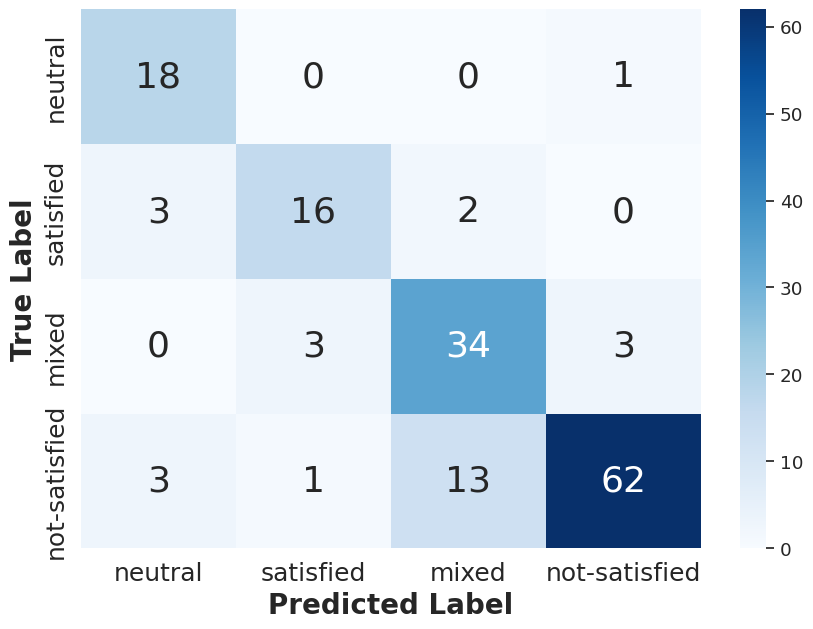

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"size": 26})  # Increase font size here
    plt.xlabel('Predicted Label', fontsize=20, fontweight='bold')
    plt.ylabel('True Label', fontsize=20, fontweight='bold')
    plt.xticks(fontsize=18)  # Increase x-axis tick label size and make bold
    plt.yticks(fontsize=18)  # Increase y-axis tick label size and make bold

    plt.show()
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3])
plot_confusion_matrix(cm, labels=['neutral', 'satisfied', 'mixed', 'not-satisfied'])

# GPT-4o mini

In [ ]:
import numpy as np
import json
import os

SAVE = []

model = "ft:gpt-4o-mini-2024-07-18:leaflab:surveyanalysisfinetuning:9vzI1oD2"
system_msg = """You are a helpful and harmless AI assistant. You are helping to classify school survey comments into different categories. You will be given a school survey comment and you must respond with one of the following categories: not-satisfied, satisfied, both and neutral. Choose based on the following rules:

SATISFIED (Select if the comment reflects a high level (atleast 75%) of satisfaction, with little or no suggestions for improvement.)
DISSATISFIED (Select if the comment expresses a high level (atleast 75%) of dissatisfaction or dedicates a significant portion (atleast 75%) to suggesting improvements.)
MIXED (Select if the comment shows a balanced mix (50% each) of satisfaction and dissatisfaction/(suggestions for improvement).)
NEUTRAL (Select if there is no direct/indirect satisfation/dissatisfaction/suggestions and the respondent has not personally used or experienced mental health services.)
"""
client = OpenAI(api_key = "")

y_pred = []

dir = '/content/drive/MyDrive/github_LEAF_LAB/survey_analysis/finetuned_results/gpt4o_mini/'
file_path = os.path.join(dir, '9vzI1oD2')

if not os.path.exists(dir):
  os.makedirs(dir)

for idx, msg in enumerate(x_test):
  answer = pipeline_desc(msg, client, model, system_msg)

  prediction = answer
  print(f'--------{idx}-START------------------------------------------------')
  print(f'Comment: {msg} \n\n')
  print(f'Label: {mapping["class_mapping_reverse"][str(y_test[idx])]}')
  print(f'Result: {prediction}')
  print(f'--------{idx}-END--------------------------------------------------')

  y_pred.append(mapping["class_mapping"][prediction])

  SAVE.append({'comment':msg, 'list':prediction})


  # save the SAVE as json in local
  with open(file_path, 'w') as outfile:
    json.dump(SAVE, outfile)

NotFoundError: Error code: 404 - {'error': {'message': 'The model `ft:gpt-4o-mini-2024-07-18:leaflab:surveyanalysisfinetuning:9vzI1oD2` does not exist or you do not have access to it.', 'type': 'invalid_request_error', 'param': None, 'code': 'model_not_found'}}

In [ ]:
with open(file_path, 'r') as f:
  predictions = json.load(f)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.51      1.00      0.68        19
           1       0.76      0.76      0.76        21
           2       0.83      0.60      0.70        40
           3       0.92      0.84      0.87        79

    accuracy                           0.79       159
   macro avg       0.75      0.80      0.75       159
weighted avg       0.83      0.79      0.79       159



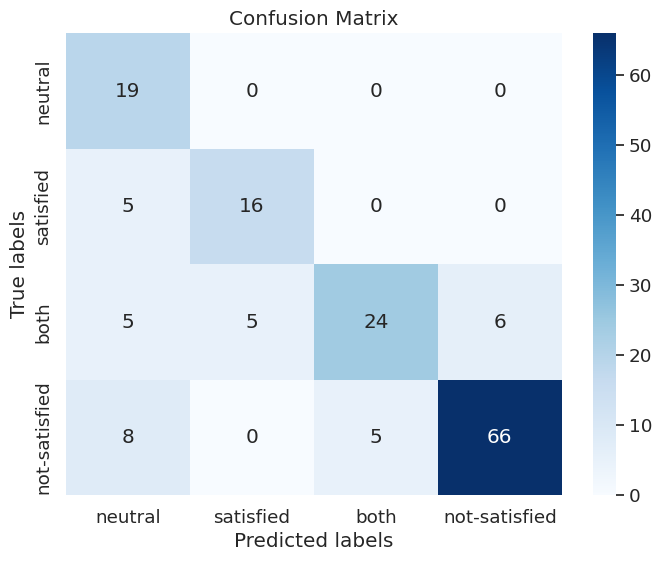

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3])
plot_confusion_matrix(cm, labels=['neutral', 'satisfied', 'both', 'not-satisfied'])

# Prompt Engineering Test Results

In [ ]:
# x_train, y_train, x_val, y_val, x_test, y_test
# train, val, test, mapping

import json
import os

# Function to load JSON from a file
def load_json(folder_path, file_name):
    file_path = os.path.join(folder_path, file_name)
    with open(file_path, "r") as f:
        data = json.load(f)
    return data

# Function to load all JSONs (train, val, test, mapping) into respective variables
def load_all_jsons(folder_path):
    train = load_json(folder_path, "train.json")
    val = load_json(folder_path, "val.json")
    test = load_json(folder_path, "test.json")
    mapping = load_json(folder_path, "mapping.json")

    return train, val, test, mapping

# Example usage:
output_folder = "/content/drive/MyDrive/github_LEAF_LAB/survey_analysis/splits/20240813/"
train, val, test, mapping = load_all_jsons(output_folder)


In [ ]:
mapping

{'class_mapping': {'not-satisfied': 3,
  'satisfied': 1,
  'both': 2,
  'neutral': 0},
 'class_mapping_reverse': {'3': 'not-satisfied',
  '1': 'satisfied',
  '2': 'both',
  '0': 'neutral'}}

In [ ]:
def transform_test(test, mapping):
  transformed_test = []
  for record in test:
    transformed_record = record.copy() # Create a copy to avoid modifying original
    transformed_record['label'] = mapping['class_mapping_reverse'][str(record['label'])]
    transformed_test.append(transformed_record)
  return transformed_test

transformed_test = transform_test(test, mapping)

In [ ]:
import pandas as pd

all_results_path = "/content/drive/MyDrive/github_LEAF_LAB/survey_analysis/updated_results/results_gpt_mistral_orca_llama.csv"


all_results = pd.read_csv(all_results_path)

In [ ]:
all_results

,Unnamed: 0,Gpt-3.5-turbo-desc_few_shot,Gpt-3.5-turbo-desc,Mistral-v2-instruct-desc,Orca-instruct-desc,LlaMA-2-7b-chat-desc,comment,Validated_Labels
0,0,DISSATISFIED,DISSATISFIED,NEUTRAL,MIXED,MIXED,i don’t know what services are working well be...,DISSATISFIED
1,1,DISSATISFIED,DISSATISFIED,DISSATISFIED,DISSATISFIED,DISSATISFIED,the appointment system for mental health servi...,DISSATISFIED
2,2,NEUTRAL,NEUTRAL,NEUTRAL,NEUTRAL,NEUTRAL,i haven't really tried to access mental health...,NEUTRAL
3,3,MIXED,MIXED,NEUTRAL,MIXED,MIXED,"cmhc is pretty good, but it seems confusing to...",MIXED
4,4,MIXED,MIXED,SATISFIED,MIXED,MIXED,there is one counselor that the college pays f...,MIXED
...,...,...,...,...,...,...,...,...
788,788,DISSATISFIED,MIXED,MIXED,MIXED,MIXED,tuttleman counseling is nice when you have acc...,DISSATISFIED
789,789,MIXED,DISSATISFIED,MIXED,NaN,MIXED,i haven’t been provided with very many service...,DISSATISFIED
790,790,DISSATISFIED,DISSATISFIED,DISSATISFIED,DISSATISFIED,DISSATISFIED,"no, they just redirect me to my in network res...",DISSATISFIED
791,791,SATISFIED,SATISFIED,SATISFIED,NaN,NEUTRAL,the mental health service that is helping stud...,SATISFIED


In [ ]:
all_results["Validated_Labels"].value_counts()

,count
Validated_Labels,
DISSATISFIED,376
MIXED,220
SATISFIED,107
NEUTRAL,90


In [ ]:
import math

def transform_records(record_list, test):
  mapping = {
      'MIXED': 'both',
      'DISSATISFIED': 'not-satisfied',
      'SATISFIED': 'satisfied',
      'NEUTRAL': 'neutral',
  }

  exclude = ['Unnamed: 0', 'comment']

  results = {}
  nans = {}

  test_comments = [record['text'] for record in test]

  for record in record_list:
    if record['comment'] in test_comments:
      for key, value in record.items():
          if key not in exclude:
            if key not in results:
              results[key] = []
              nans[key] = 0

            if value != 'SKIP':
              if not pd.isna(value):
                results[key].append({
                    'text' : record['comment'],
                    'label': mapping[value]
                })
              else:
                nans[key] += 1

  return results, nans

results, nans = transform_records(all_results.to_dict(orient='records'),
                            transformed_test)

In [ ]:
nans

{'Gpt-3.5-turbo-desc_few_shot': 0,
 'Gpt-3.5-turbo-desc': 0,
 'Mistral-v2-instruct-desc': 0,
 'Orca-instruct-desc': 31,
 'LlaMA-2-7b-chat-desc': 0,
 'Validated_Labels': 0}

In [ ]:
results

{'Gpt-3.5-turbo-desc_few_shot': [{'text': "the appointment system for mental health services is bad. it doesn't represent the full range of services.",
   'label': 'not-satisfied'},
  {'text': "there is a counselor and an online quiz thing. i'm an online student",
   'label': 'neutral'},
  {'text': 'medical care and pharmacy services are good, but mental health is inaccessible and has bad rep ',
   'label': 'not-satisfied'},
  {'text': 'i know we have the wellness center but i have not used it. from my friends that have i hear staffing is the biggest issue since there are so many students and not enough counselors.',
   'label': 'not-satisfied'},
  {'text': 'i can think of one thing that works well. but as an online student referrals to services near me would be great.',
   'label': 'both'},
  {'text': 'more checking in on students’ mental health and easy access to resources',
   'label': 'satisfied'},
  {'text': "not sure i have not used the services because i honestly didn't know abo

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"size": 26})  # Increase font size here
    plt.xlabel('Predicted Label', fontsize=20, fontweight='bold')
    plt.ylabel('True Label', fontsize=20, fontweight='bold')
    plt.xticks(fontsize=18)  # Increase x-axis tick label size and make bold
    plt.yticks(fontsize=18)  # Increase y-axis tick label size and make bold

    plt.show()

def compare_labels_and_metrics(test_list, pred_list):
    """
    Compares the labels in the test list and pred list for the same text and computes precision, recall, and F1-score.

    Args:
        test_list (list): A list of dictionaries containing 'text' and 'label' keys (ground truth).
        pred_list (list): A list of dictionaries containing 'text' and 'label' keys (predictions).

    Returns:
        dict: A dictionary containing the comparison results, precision, recall, and F1-score.
    """

    # Create dictionaries mapping text to labels
    test_dict = {record['text']: record['label'] for record in test_list}
    pred_dict = {record['text']: record['label'] for record in pred_list}

    # Initialize lists for test and predicted labels
    y_true = []
    y_pred = []

    # Compare labels and build lists for metrics
    comparison_results = []

    for text, test_label in test_dict.items():
        pred_label = pred_dict.get(text)
        y_true.append(test_label)
        y_pred.append(pred_label)

        # _match = test_label == pred_label
        # if not _match:
        comparison_results.append({
            "text": text,
            "test_label": test_label,
            "pred_label": pred_label,
            "match": test_label == pred_label
        })

    # Calculate precision, recall, and F1-score
    # Assuming 'mapping' contains the mapping from class indices to labels
    class_mapping_reverse = mapping['class_mapping_reverse']

    # Print classification report
    # print(y_pred)
    report = classification_report(y_true, y_pred,
                                   target_names=['neutral', 'satisfied', 'mixed', 'not-satisfied']
                                   )
    print(report)

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred,
                          # labels=[0, 1, 2, 3]
                          )
    plot_confusion_matrix(cm,
                          labels=['neutral', 'satisfied', 'mixed', 'not-satisfied']
                          )

    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)



    return {
        "report": comparison_results,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

Gpt-3.5-turbo-desc_few_shot
               precision    recall  f1-score   support

      neutral       0.69      0.82      0.75        40
    satisfied       0.74      0.89      0.81        19
        mixed       0.98      0.76      0.86        79
not-satisfied       0.67      0.86      0.75        21

     accuracy                           0.81       159
    macro avg       0.77      0.83      0.79       159
 weighted avg       0.84      0.81      0.81       159



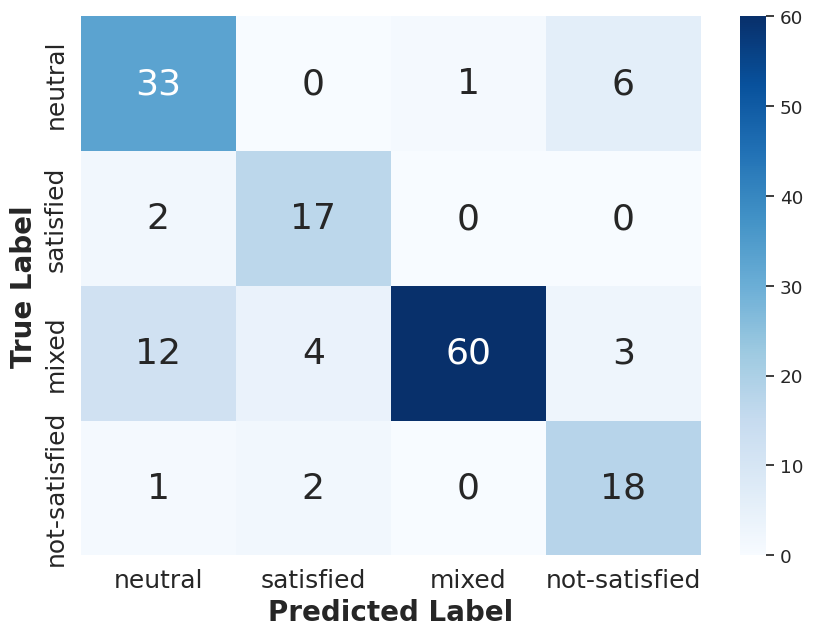

Gpt-3.5-turbo-desc
               precision    recall  f1-score   support

      neutral       0.62      0.78      0.69        40
    satisfied       0.81      0.89      0.85        19
        mixed       1.00      0.75      0.86        79
not-satisfied       0.66      0.90      0.76        21

     accuracy                           0.79       159
    macro avg       0.77      0.83      0.79       159
 weighted avg       0.84      0.79      0.80       159



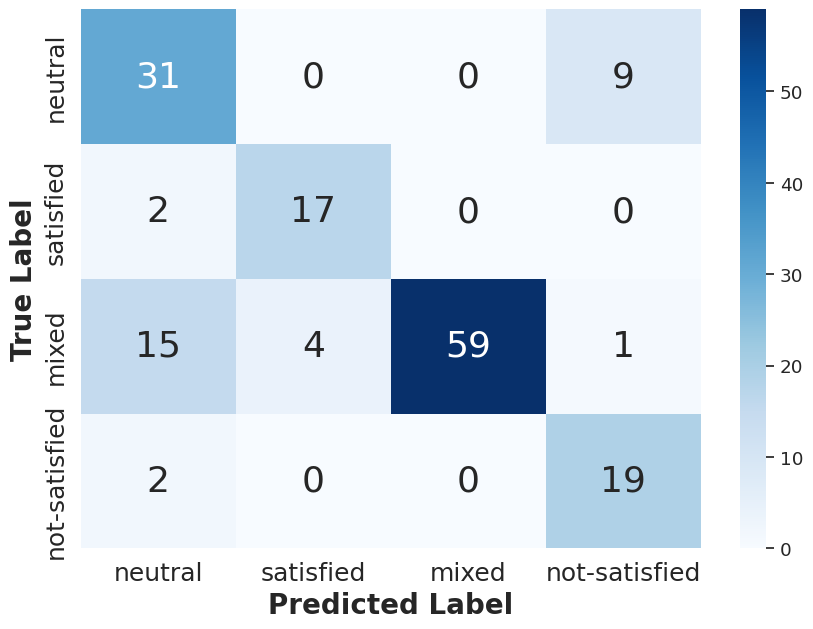

Mistral-v2-instruct-desc
               precision    recall  f1-score   support

      neutral       0.56      0.50      0.53        40
    satisfied       0.28      1.00      0.43        19
        mixed       0.98      0.52      0.68        79
not-satisfied       0.83      0.48      0.61        21

     accuracy                           0.57       159
    macro avg       0.66      0.62      0.56       159
 weighted avg       0.77      0.57      0.60       159



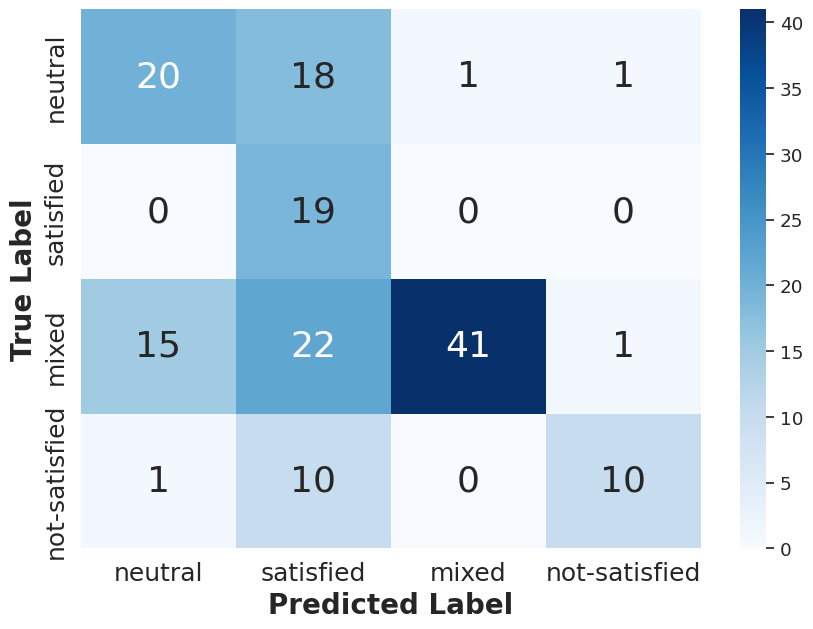

LlaMA-2-7b-chat-desc
               precision    recall  f1-score   support

      neutral       0.50      0.95      0.66        40
    satisfied       0.52      0.79      0.62        19
        mixed       0.93      0.63      0.75        79
not-satisfied       0.00      0.00      0.00        21

     accuracy                           0.65       159
    macro avg       0.49      0.59      0.51       159
 weighted avg       0.65      0.65      0.61       159



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


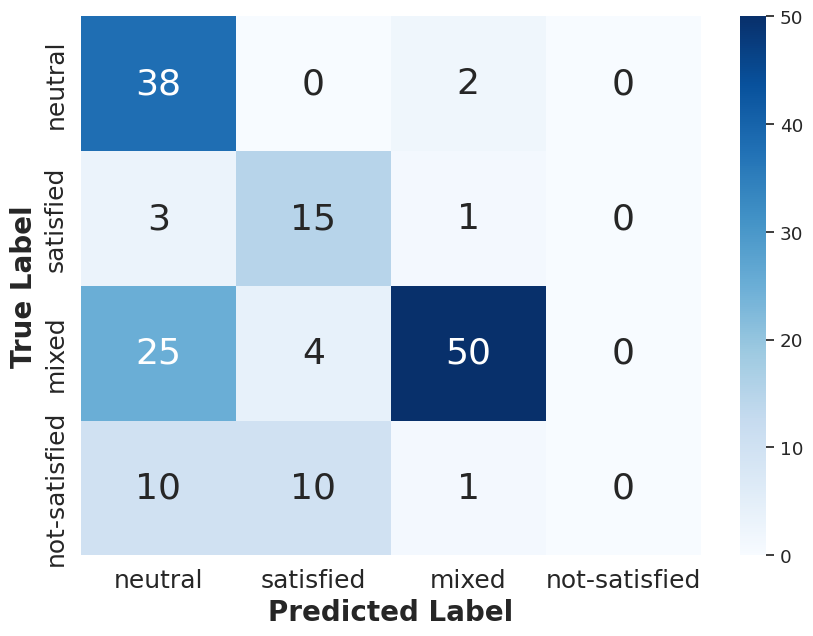

Validated_Labels
               precision    recall  f1-score   support

      neutral       0.84      0.90      0.87        40
    satisfied       0.94      0.89      0.92        19
        mixed       0.99      0.94      0.96        79
not-satisfied       0.87      0.95      0.91        21

     accuracy                           0.92       159
    macro avg       0.91      0.92      0.91       159
 weighted avg       0.93      0.92      0.93       159



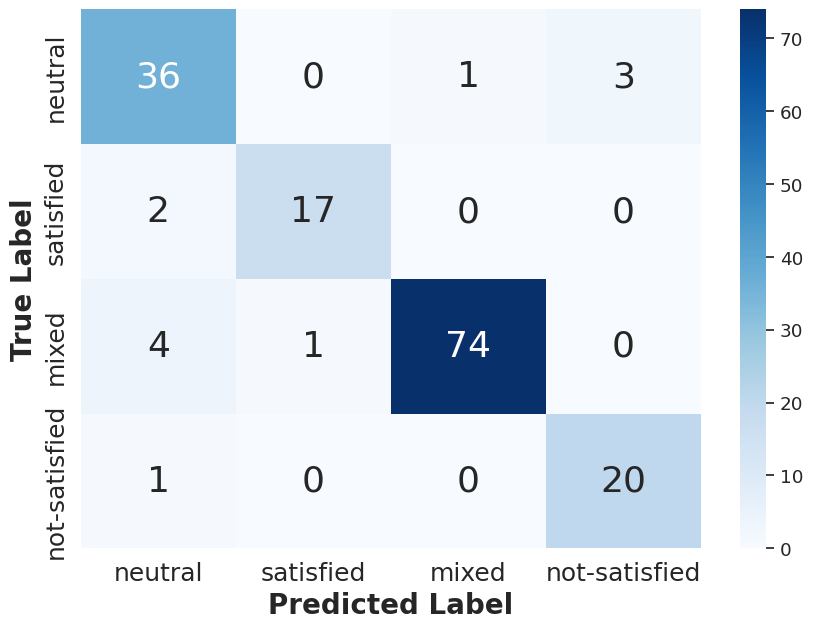

In [ ]:
metrics = {}

for key in results.keys():
  if key != 'Orca-instruct-desc':
    print(key)
    metrics[key] = compare_labels_and_metrics(transformed_test, results[key])

# for key in results.keys():
#   print(key)
#   metrics[key] = compare_labels_and_metrics(transformed_test, results[key])

In [ ]:
metrics

{'Gpt-3.5-turbo-desc_few_shot': {'precision': 0.8380402282619902,
  'recall': 0.8050314465408805,
  'f1_score': 0.8103474094040132},
 'Gpt-3.5-turbo-desc': {'precision': 0.8360979438402991,
  'recall': 0.7924528301886793,
  'f1_score': 0.8001023911524322},
 'Mistral-v2-instruct-desc': {'precision': 0.7677556849008859,
  'recall': 0.5660377358490566,
  'f1_score': 0.6007650304616993},
 'LlaMA-2-7b-chat-desc': {'precision': 0.6476461280191491,
  'recall': 0.6477987421383647,
  'f1_score': 0.6130842313982745},
 'Validated_Labels': {'precision': 0.9285556777946651,
  'recall': 0.9245283018867925,
  'f1_score': 0.9256052934161594}}

In [ ]:
pd.DataFrame(metrics).T

,precision,recall,f1_score
Gpt-3.5-turbo-desc_few_shot,0.838040,0.805031,0.810347
Gpt-3.5-turbo-desc,0.836098,0.792453,0.800102
Mistral-v2-instruct-desc,0.767756,0.566038,0.600765
LlaMA-2-7b-chat-desc,0.647646,0.647799,0.613084
Validated_Labels,0.928556,0.924528,0.925605


# Inference

In [ ]:
import json
import os

# Function to load JSON from a file
def load_json(folder_path, file_name):
    file_path = os.path.join(folder_path, file_name)
    with open(file_path, "r") as f:
        data = json.load(f)
    return data

# Function to load all JSONs (train, val, test, mapping) into respective variables
def load_all_jsons(folder_path):
    train = load_json(folder_path, "train.json")
    val = load_json(folder_path, "val.json")
    test = load_json(folder_path, "test.json")
    mapping = load_json(folder_path, "mapping.json")

    return train, val, test, mapping

# Example usage:
output_folder = "../data/splits/"
train, val, test, mapping = load_all_jsons(output_folder)

In [ ]:
def merge_datasets(train, val, test):
  merged_dataset = train + val + test
  return merged_dataset

merged_data = merge_datasets(train, val, test)

In [ ]:
import numpy as np

x = [record['text'] for record in merged_data]
y = np.asarray([record['label'] for record in merged_data])

In [ ]:
import pandas as pd
df_merged = pd.DataFrame(merged_data)

ORCA


In [ ]:
pipeline_kwargs = {
                  # 'max_length'=4096,
                  'max_new_tokens' : 100,
                  # 'min_length': 100,
                  # 'early_stopping':True,
                  'do_sample':True,
                  'top_k':10,
                  # 'top_p':0.9,
                  'temperature':0.002,
                  # 'num_return_sequences':1,
                  # 'no_repeat_ngram_size': 2,
                  'return_full_text':False,
                  # 'eos_token_id':tokenizer.eos_token_id
                  # 'max_length':2000,
                  }

In [ ]:
pipeline = create_pipeline("microsoft/Orca-2-7b")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/582 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

pytorch_model-00001-of-00003.bin:   0%|          | 0.00/9.88G [00:00<?, ?B/s]

### prep_prompt_classification_with_direct_labels

In [ ]:
import numpy as np
import json

SAVE = []

for idx, row in data_df.iterrows():
  prompt = prep_prompt_classification_with_direct_labels(row)
  answer = pipeline(prompt, client)

  prediction = answer
  print(f'--------{idx}-START------------------------------------------------')
  print(f'Comment: {row["Comment"]} \n\n')
  print(f'Label: {row["Validated_Labels"]}')
  print(f'Result: {prediction}')
  print(f'--------{idx}-END--------------------------------------------------')


  SAVE.append({'prompt':prompt, 'comment':row["Comment"], 'list':prediction})

  # save the SAVE as json in local
  with open('/content/drive/MyDrive/github_LEAF_LAB/survey_analysis/prompt_results/SAVE_gpt_3.5_survey_classification_with_direct_labels.json', 'w') as outfile:
    json.dump(SAVE, outfile)


Streaming output truncated to the last 5000 lines.
--------509-END--------------------------------------------------
--------510-START------------------------------------------------
Comment: there are definitely known resources like counselors and group therapy, but it is difficult to get appointments.  


Label: not-satisfied
Result: 2: dissatisfied.
--------510-END--------------------------------------------------
--------511-START------------------------------------------------
Comment: they have a lot but i don't know much about them in general since i don't use them. 


Label: neutral
Result: 4: neutral.
--------511-END--------------------------------------------------
--------512-START------------------------------------------------
Comment: i feel the use of tele-health has been expanded during covid and can make a good impact  


Label: satisfied
Result: 1: satisfied
--------512-END--------------------------------------------------
--------513-START----------------------------

### prep_prompt_classification_with_desc

In [ ]:
def prep_prompt_classification_orca_desc(row):

  prompt = f"""
You are a very experienced analyst, who is trying to analyze the answers to a question asked during a mental health survey. No answer will explicitly mention any of the categories. You have to analyse them based on the rules and answer one word, SATISFIED, DISSATISFIED, MIXED, or NEUTRAL.

Question: Can you share your thoughts on the mental health or wellness services at your college? Identify aspects that are working well and areas that may need more attention.

Since the question mentioned has two questions in itself. First, analyze which part of the answer corresponds to which part of the question. And then classify them based on the below rules:

- SATISFIED (If at least 75% of the words are dedicated to expressing satisfaction and only a small portion of words are dedicated to suggestions for improvement.)
- DISSATISFIED (If at least 75% of the words are dedicated to expressing dissatisfaction or suggestions for improvement, and there are little to no words that mention satisfaction.)
- MIXED (If the words dedicated to expressing satisfaction and dissatisfaction/suggestions for improvement are almost equal (around 50% each).)
- NEUTRAL (If there is no clear dedication of words towards satisfaction, dissatisfaction, or suggestions for improvement.

Respondent - {row["text"]}

Just give ONE WORD (Satisfied, dissatisfied, Neutral or Mixed.) as the answer to the above question. The answer is:
  """

  return prompt

In [ ]:
import pandas as pd
df_merged = pd.DataFrame(merged_data)

In [ ]:
import numpy as np
import json

SAVE = []

for idx, row in df_merged.iterrows():
  prompt = prep_prompt_classification_orca_desc(row)
  answer = pipeline(prompt,
                    **pipeline_kwargs
                    )

  prediction = answer[0]["generated_text"]
  print(f'--------{idx}-START------------------------------------------------')
  print(f'Comment: {row["text"]} \n\n')
  print(f'Label: {row["label"]}')
  print(f'Result: {prediction}')
  print(f'--------{idx}-END--------------------------------------------------')


  SAVE.append({'comment':row["text"], 'list':prediction})

  # save the SAVE as json in local
  with open('/content/drive/MyDrive/github_LEAF_LAB/survey_analysis/prompt_results/Orca-desc_prompt-fulldata.json', 'w') as outfile:
    json.dump(SAVE, outfile)


NameError: name 'pipeline' is not defined

### prep_prompt_classification_with_role_prompting



In [ ]:
import numpy as np
import json

SAVE = []

for idx, row in data_df.iterrows():
  prompt = prep_prompt_classification_with_role_prompting(row)
  answer = pipeline(prompt, client)

  prediction = answer
  print(f'--------{idx}-START------------------------------------------------')
  print(f'Comment: {row["Comment"]} \n\n')
  print(f'Label: {row["Validated_Labels"]}')
  print(f'Result: {prediction}')
  print(f'--------{idx}-END--------------------------------------------------')

  SAVE.append({'prompt':prompt, 'comment':row["Comment"], 'list':prediction})

  # save the SAVE as json in local
  with open('/content/drive/MyDrive/github_LEAF_LAB/survey_analysis/prompt_results/SAVE_gpt_3.5_survey_classification_with_role_prompting.json', 'w') as outfile:
    json.dump(SAVE, outfile)

Streaming output truncated to the last 5000 lines.
--------515-START------------------------------------------------
Comment: i personally have not used the mental health facilities on campus because they have a poor reputation  


Label: not-satisfied
Result: Mixed (Select if the comment shows a balanced mix (50% each) of satisfaction and dissatisfaction/(suggestions for improvement).)
--------515-END--------------------------------------------------
--------516-START------------------------------------------------
Comment: there are many psychological consultants available for appointment, and you can talk about your troubles at any time. 


Label: satisfied
Result: Mixed (as they mentioned that there are many psychological consultants available and you can talk about your troubles at any time, but also suggest that there may be areas that need more attention).
--------516-END--------------------------------------------------
--------517-START-----------------------------------------

### prep_prompt_classification_with_zero_shot_COT

In [ ]:
import numpy as np
import json

SAVE = []

for idx, row in data_df.iterrows():
  prompt = prep_prompt_classification_with_zero_shot_COT(row)
  answer = pipeline(prompt, client)

  prediction = answer
  print(f'--------{idx}-START------------------------------------------------')
  print(f'Comment: {row["Comment"]} \n\n')
  print(f'Label: {row["Validated_Labels"]}')
  print(f'Result: {prediction}')
  print(f'--------{idx}-END--------------------------------------------------')


  SAVE.append({'prompt':prompt, 'comment':row["Comment"], 'list':prediction})

  # save the SAVE as json in local
  with open('/content/drive/MyDrive/github_LEAF_LAB/survey_analysis/prompt_results/SAVE_gpt_3.5_survey_classification_with_zero_shot_COT.json', 'w') as outfile:
    json.dump(SAVE, outfile)

Streaming output truncated to the last 5000 lines.
Result: MIXED
--------550-END--------------------------------------------------
--------551-START------------------------------------------------
Comment: i think the wellness chat that is offered commonly during the week by the cfs works well 


Label: satisfied
Result: 
SATISFIED
--------551-END--------------------------------------------------
--------552-START------------------------------------------------
Comment: i am not sure as i have not used the mental health services offered at my school 


Label: neutral
Result: NEUTRAL
--------552-END--------------------------------------------------
--------553-START------------------------------------------------
Comment: i believe that asu counseling service is working well at helping students with their mental health  


Label: satisfied
Result: 
MIXED
--------553-END--------------------------------------------------
--------554-START------------------------------------------------
Co

### prep_prompt_classification_with_tree_of_thoughts

In [ ]:
import numpy as np
import json

SAVE = []

for idx, row in data_df.iterrows():
  prompt = prep_prompt_classification_with_tree_of_thoughts(row)
  answer = pipeline(prompt, client)

  prediction = answer
  print(f'--------{idx}-START------------------------------------------------')
  print(f'Comment: {row["Comment"]} \n\n')
  print(f'Label: {row["Validated_Labels"]}')
  print(f'Result: {prediction}')
  print(f'--------{idx}-END--------------------------------------------------')


  SAVE.append({'prompt':prompt, 'comment':row["Comment"], 'list':prediction})

  # save the SAVE as json in local
  with open('/content/drive/MyDrive/github_LEAF_LAB/survey_analysis/prompt_results/SAVE_gpt_3.5_survey_classification_with_tree_of_thoughts.json', 'w') as outfile:
    json.dump(SAVE, outfile)

Streaming output truncated to the last 5000 lines.
--------540-START------------------------------------------------
Comment: need more counselors for the number of students. add a psychiatrist who can prescribe medications affordably.  


Label: not-satisfied
Result: 2: DISSATISFIED
--------540-END--------------------------------------------------
--------541-START------------------------------------------------
Comment: counseling. i have appreciated using therapy on campus and i know many others feel the same way. 


Label: satisfied
Result: 3: MIXED
--------541-END--------------------------------------------------
--------542-START------------------------------------------------
Comment: wellness information services and events are working well, however the therapists available and staffing need more funding. 


Label: both
Result: 3: MIXED
--------542-END--------------------------------------------------
--------543-START------------------------------------------------
Comment: th

### prep_prompt_classification_with_steps_few_shot_COT

In [ ]:
import numpy as np
import json

SAVE = []

for idx, row in data_df.iterrows():
  prompt = prep_prompt_classification_with_steps_few_shot_COT(row)
  answer = pipeline(prompt, client)

  prediction = answer
  print(f'--------{idx}-START------------------------------------------------')
  print(f'Comment: {row["Comment"]} \n\n')
  print(f'Label: {row["Validated_Labels"]}')
  print(f'Result: {prediction}')
  print(f'--------{idx}-END--------------------------------------------------')


  SAVE.append({'prompt':prompt, 'comment':row["Comment"], 'list':prediction})

  # save the SAVE as json in local
  with open('/content/drive/MyDrive/github_LEAF_LAB/survey_analysis/prompt_results/SAVE_gpt_3.5_survey_classification_with_steps_few_shot_COT.json', 'w') as outfile:
    json.dump(SAVE, outfile)

Streaming output truncated to the last 5000 lines.
--------635-START------------------------------------------------
Comment: trying to make an appointment with on campus counseling was really hard for me  


Label: not-satisfied
Result:  more attention is needed to improve availability of appointments
1. trying to make an appointment with on campus counseling was really hard for me is the answer to this part of the question (What mental health or wellness services and supports provided by your college are working well or need more attention?)
 more attention is needed to improve availability of appointments is the answer to this part of the question (What aspects of mental health and wellness need more attention?)
2. trying to make an appointment with on campus counseling was really hard for me is DISSATISFIED and more attention is needed to improve availability of appointments is DISSATISFIED.
3. DISSATISFIED overpowers SATISFIED, thus the sentiment of the comment is DISSATISFIED.
An

### prep_prompt_classification_with_steps_few_shot_COT1

In [ ]:
import numpy as np
import json

SAVE = []

for idx, row in data_df.iterrows():
  prompt = prep_prompt_classification_with_steps_few_shot_COT1(row)
  answer = pipeline(prompt, client)

  prediction = answer
  print(f'--------{idx}-START------------------------------------------------')
  print(f'Comment: {row["Comment"]} \n\n')
  print(f'Label: {row["Validated_Labels"]}')
  print(f'Result: {prediction}')
  print(f'--------{idx}-END--------------------------------------------------')


  SAVE.append({'prompt':prompt, 'comment':row["Comment"], 'list':prediction})

  # save the SAVE as json in local
  with open('/content/drive/MyDrive/github_LEAF_LAB/survey_analysis/prompt_results/SAVE_gpt_3.5_survey_classification_with_steps_few_shot_COT1.json', 'w') as outfile:
    json.dump(SAVE, outfile)

Streaming output truncated to the last 5000 lines.


Label: not-satisfied
Result: 
Identify the positive aspect of the college's mental health services: None - the respondent has not used the services.
Identify the area that requires improvement: "Counseling offered is poor" indicates DISSATISFACTION.
Assess the sentiment:
No positive aspect was mentioned, and the comment expresses DISSATISFACTION, so the sentiment is DISSATISFIED.
Answer: DISSATISFIED
--------636-END--------------------------------------------------
--------637-START------------------------------------------------
Comment: more access and awareness for guys seeking mental health and being comfortable with expressing themselves. 


Label: not-satisfied
Result: 
Identify the positive aspect of the college's mental health services: "More access and awareness for guys seeking mental health" answers the question, "What mental health or wellness services and supports provided by your college are working well?"
Identify the 